In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

dataset_filepath =os.getenv('HOME') + '/aiffel/stock_prediction/data/005380.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2021-11-11    205000.0
2021-11-12    208000.0
2021-11-15    209000.0
2021-11-16    206500.0
2021-11-17    207000.0
Name: Close, dtype: float64

In [2]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [3]:
ts_log = np.log(ts)

In [4]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [5]:
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

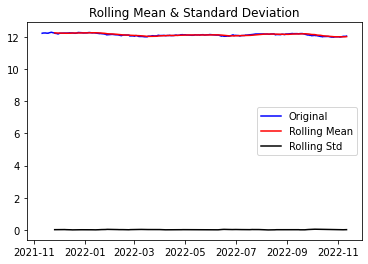

Results of Dickey-Fuller Test:
Test Statistic                  -1.812318
p-value                          0.374364
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


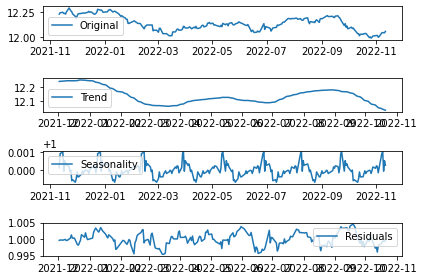

In [6]:
plot_rolling_statistics(ts_log, window=12)

augmented_dickey_fuller_test(ts_log)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.146150
p-value                          0.000011
#Lags Used                       0.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


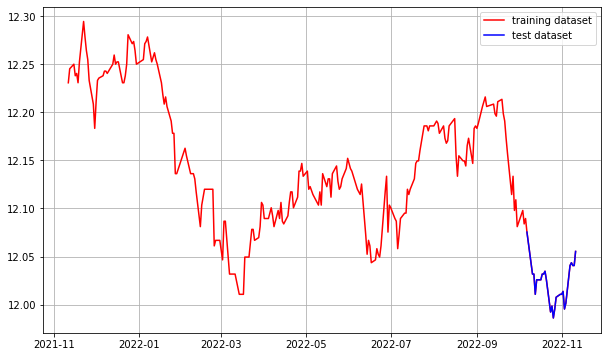

In [8]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


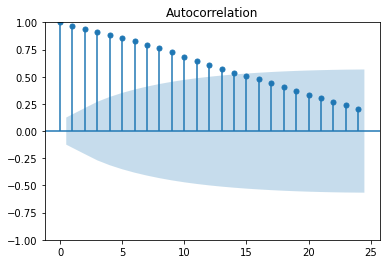

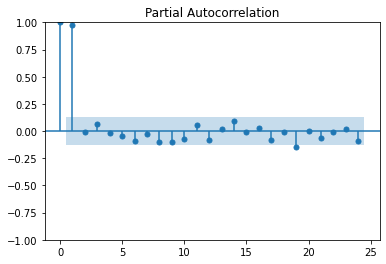

In [9]:
plot_acf(ts_log)   
plot_pacf(ts_log)  
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.631719e+01
p-value                        3.153630e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


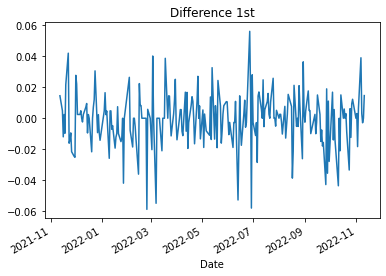

In [10]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.684140e+00
p-value                        4.207803e-14
#Lags Used                     9.000000e+00
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


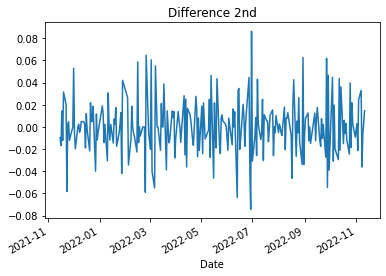

In [11]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [15]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 588.746
Date:                Fri, 11 Nov 2022   AIC                          -1167.492
Time:                        07:34:05   BIC                          -1150.501
Sample:                             0   HQIC                         -1160.631
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1517      0.033    363.961      0.000      12.086      12.217
ar.L1          0.1972      1.637      0.121      0.904      -3.011       3.405
ar.L2          0.7475      1.601      0.467      0.6

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


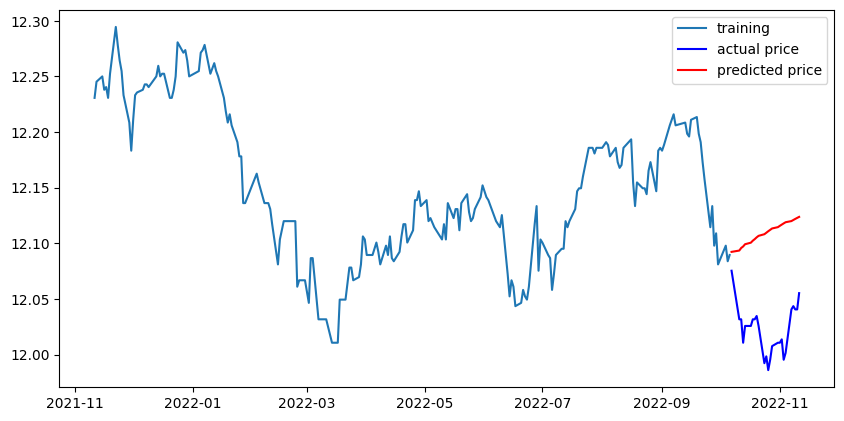

In [17]:

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [18]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  247937734.59738445
MAE:  15191.43092934853
RMSE:  15746.038695411124
MAPE: 9.18%


In [22]:
dataset_filepath =os.getenv('HOME') + '/aiffel/stock_prediction/data/000660.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
sk_ts = df['Close']
print(type(ts))
sk_ts.head()

<class 'pandas.core.series.Series'>


Date
2021-11-11    107500.0
2021-11-12    106500.0
2021-11-15    111000.0
2021-11-16    112000.0
2021-11-17    110500.0
Name: Close, dtype: float64

In [23]:
sk_ts=sk_ts.interpolate(method='time')
sk_ts[sk_ts.isna()]

Series([], Name: Close, dtype: float64)

In [24]:
sk_ts_log = np.log(sk_ts)

In [25]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [26]:
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

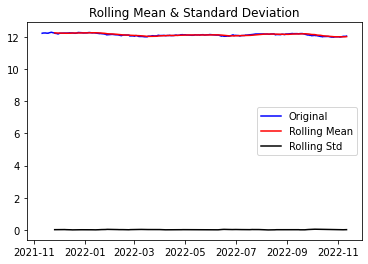

Results of Dickey-Fuller Test:
Test Statistic                  -0.386519
p-value                          0.912325
#Lags Used                      16.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


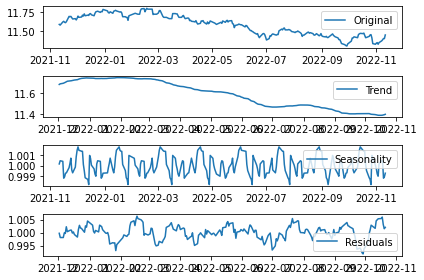

In [28]:
plot_rolling_statistics(ts_log, window=12)

augmented_dickey_fuller_test(sk_ts_log)

decomposition = seasonal_decompose(sk_ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(sk_ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [29]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.097395
p-value                          0.000014
#Lags Used                      13.000000
Number of Observations Used    202.000000
Critical Value (1%)             -3.463144
Critical Value (5%)             -2.875957
Critical Value (10%)            -2.574455
dtype: float64


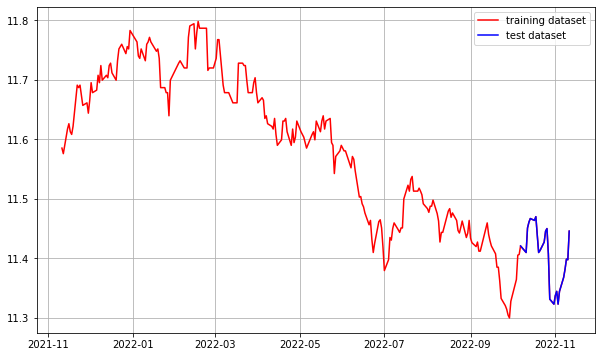

In [30]:
train_data, test_data = sk_ts_log[:int(len(sk_ts_log)*0.9)], sk_ts_log[int(len(sk_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(sk_ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


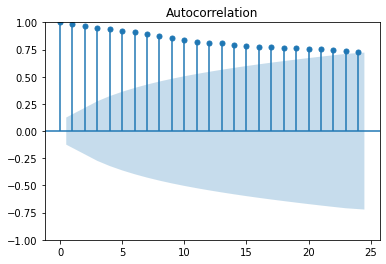

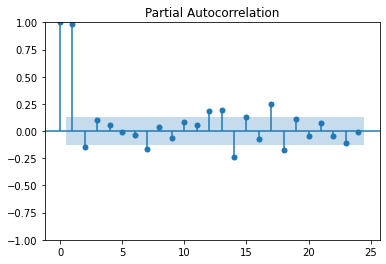

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(sk_ts_log)   
plot_pacf(sk_ts_log)  
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -5.337395
p-value                          0.000005
#Lags Used                      15.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


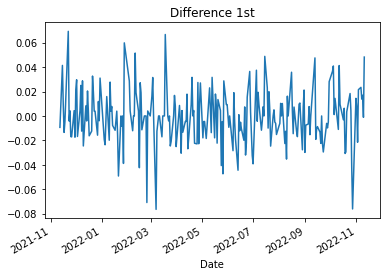

In [32]:
diff_1 = sk_ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -5.707283e+00
p-value                        7.437907e-07
#Lags Used                     1.500000e+01
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64


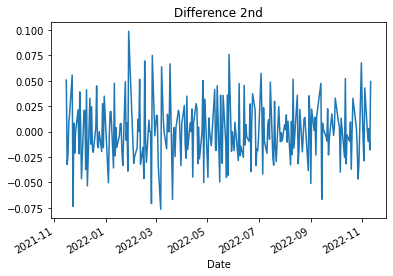

In [33]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [35]:
from statsmodels.tsa.arima.model import ARIMA


model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 534.353
Date:                Fri, 11 Nov 2022   AIC                          -1058.706
Time:                        07:52:03   BIC                          -1041.716
Sample:                             0   HQIC                         -1051.846
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.5554      0.106    108.807      0.000      11.347      11.764
ar.L1          0.1492      0.779      0.192      0.848      -1.377       1.676
ar.L2          0.8250      0.770      1.071      0.2

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


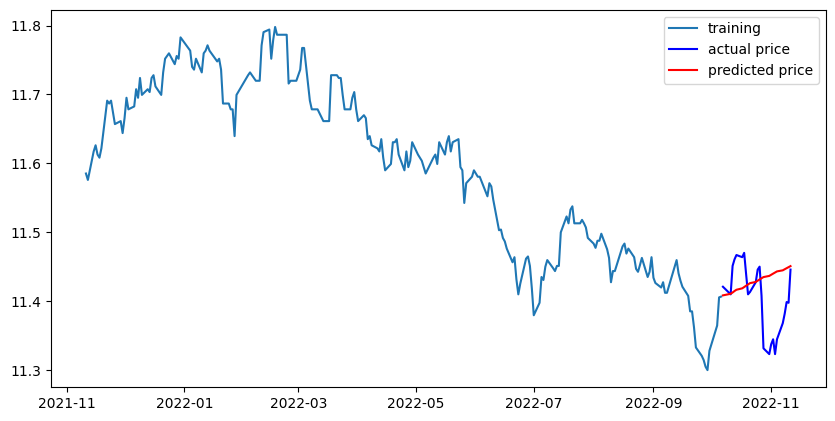

In [38]:

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  30058187.037227165
MAE:  4408.681365564905
RMSE:  5482.534727407312
MAPE: 5.05%


In [43]:
dataset_filepath =os.getenv('HOME') + '/aiffel/stock_prediction/data/035420.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts_naver = df['Close']
print(type(ts_amz))
ts_naver.head()

<class 'pandas.core.series.Series'>


Date
2021-11-12    409000.0
2021-11-15    411000.0
2021-11-16    405500.0
2021-11-17    401000.0
2021-11-18    407000.0
Name: Close, dtype: float64

In [44]:
ts_naver=ts_naver.interpolate(method='time')
ts_naver[ts_naver.isna()]

Series([], Name: Close, dtype: float64)

In [45]:
ts_naver_log = np.log(ts_naver)

In [46]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [47]:
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

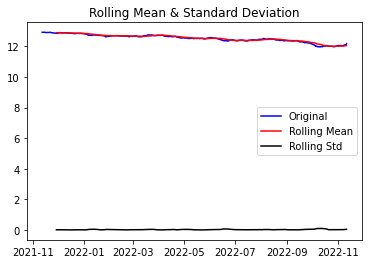

Results of Dickey-Fuller Test:
Test Statistic                  -0.894889
p-value                          0.789651
#Lags Used                       0.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


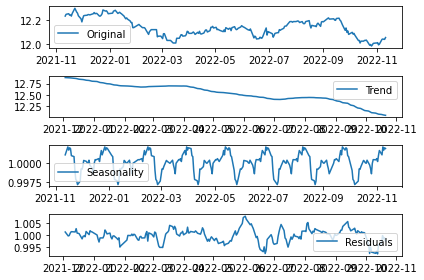

In [48]:
plot_rolling_statistics(ts_naver_log, window=12)

augmented_dickey_fuller_test(ts_naver_log)

decomposition = seasonal_decompose(ts_naver_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [49]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.201185
p-value                          0.000009
#Lags Used                       3.000000
Number of Observations Used    211.000000
Critical Value (1%)             -3.461727
Critical Value (5%)             -2.875337
Critical Value (10%)            -2.574124
dtype: float64


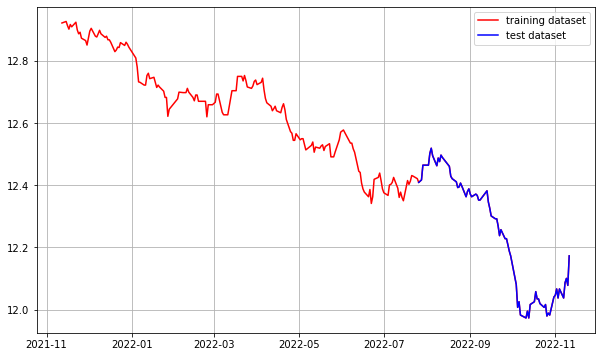

In [50]:
train_data, test_data = ts_naver_log[:int(len(ts_naver_log)*0.7)], ts_naver_log[int(len(ts_naver_log)*0.7):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_naver_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


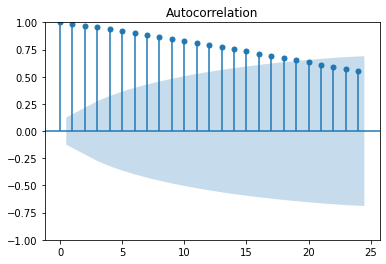

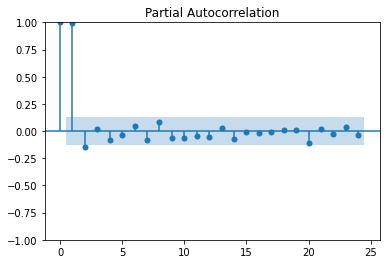

In [51]:
plot_acf(ts_naver_log)   
plot_pacf(ts_naver_log)  
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.322087e+00
p-value                        1.186882e-10
#Lags Used                     3.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


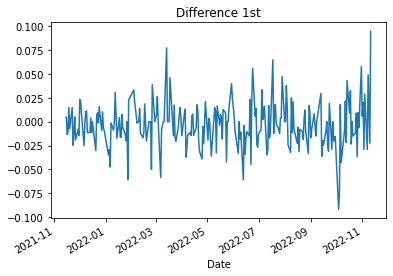

In [54]:
diff_1 = ts_naver_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.185128e+00
p-value                        7.937402e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


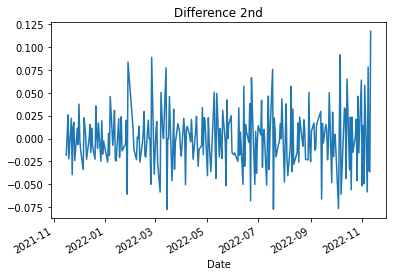

In [55]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [57]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
# [[YOUR CODE]]
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  171
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 413.425
Date:                Fri, 11 Nov 2022   AIC                           -816.850
Time:                        08:11:41   BIC                           -801.142
Sample:                             0   HQIC                          -810.476
                                - 171                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6744      1.390      9.117      0.000       9.950      15.399
ar.L1          0.1732      0.100      1.729      0.084      -0.023       0.370
ar.L2          0.8243      0.100      8.208      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


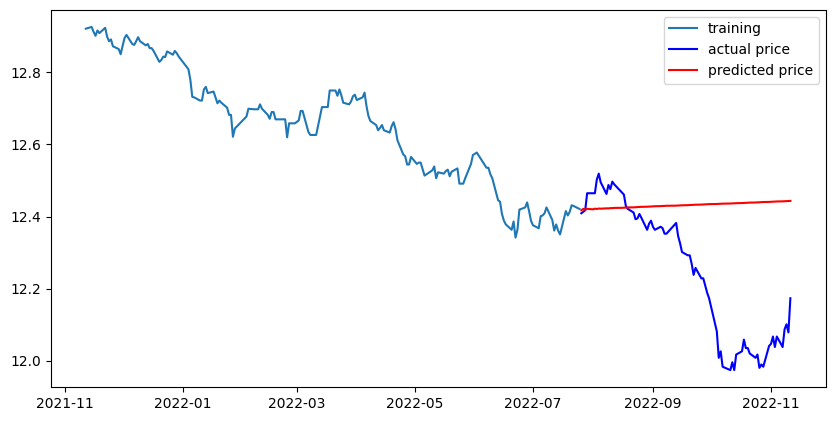

In [59]:
 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [60]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3066979656.934902
MAE:  43894.320621946456
RMSE:  55380.31831738512
MAPE: 24.39%


In [ ]:
회고
현대, sk, naver 의 주식가격을 예측해보았습니다.


각각 결과는 다음과 같습니다.
1.  Hyundai Motor Company (005380.KS)
MSE:  247937734.59738445
MAE:  15191.43092934853
RMSE:  15746.038695411124
MAPE: 9.18%


2. SK hynix Inc. (000660.KS)
MSE:  30058187.037227165
MAE:  4408.681365564905
RMSE:  5482.534727407312
MAPE: 5.05%

3. NAVER Corporation (035420.KS)
MSE:  3066979656.934902
MAE:  43894.320621946456
RMSE:  55380.31831738512
MAPE: 24.39%

    reference

https://github.com/JaeHeee/AIFFEL_Project/blob/master/EXPLORATION/EXPLORATION%206.%20%EC%96%B4%EC%A0%9C%20%EC%98%A4%EB%A5%B8%20%EB%82%B4%20%EC%A3%BC%EC%8B%9D%2C%20%EA%B3%BC%EC%97%B0%20%EB%82%B4%EC%9D%BC%EC%9D%80%3F.ipynb